In [ ]:
import numpy as np
import os
import glob
import shutil
from distutils.dir_util import copy_tree

import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE

import torch
import torchvision
from torchvision.models import resnet50
from torchvision.datasets import ImageFolder

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

!pip install torchinfo
from torchinfo import summary

!nvidia-smi

PyTorch Version:  1.7.1
Torchvision Version:  0.8.2
Fri Feb  3 16:46:11 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.34       Driver Version: 430.34       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  Off  | 00000000:19:00.0 Off |                  N/A |
| 24%   28C    P8     3W / 250W |   3139MiB / 11019MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 208...  Off  | 00000000:1A:00.0 Off |                  N/A |
| 24%   32C    P8     6W / 250W |     11MiB / 11019MiB |      0%      Default |
+-------------------------------+---

In [ ]:
!python --version

root_path = "/media/kondo/Ext4_for_Colab/tomizawa/paper/" #@param {type:"string"}
#@markdown  - Assign a path for your root directory. This root directory should include an image dataset directory ("/data/data_original/") and "/utils/" directory.
#@markdown  - The image dataset is available at a database (URL in #README on the GitHub).
#@markdown  - The library "utils" is available at the same GitHub page with this jupyter notebook.

%cd $root_path 
!pwd
!ls

Python 3.6.10 :: Anaconda, Inc.
/media/kondo/Ext4_for_Colab/tomizawa/paper
/media/kondo/Ext4_for_Colab/tomizawa/paper
data	   figures  results_old		 results_test
data_old1  results  results_randomLabel  utils


In [ ]:
from utils.loaders import Args, ImageTransform, MarchantiaDataset
from utils.misc import get_unnormalize, get_datetime, makedirs
from utils.misc import visualize_batch

In [ ]:
dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(dev)

cuda


In [ ]:
## Make dataset for tSNE.
## For dataset dedicated to tSNE, hierarchy is different from a normal dataset for classification.

strain_list = ['Tak', 'Aus', 'RIL5']
day_list = ['0d','1d','2d','3d','4d','7d']

data_path = './data/data_original/'
results_path = './data/data_tSNE/'

# make an output directory
if not os.path.isdir(results_path):
    os.mkdir(results_path)

# copy all images, but with a different directory structure
for strain in strain_list:
    for day in day_list:
        src_dname = data_path + strain + '/' + day + '/'
        for class_path in glob.glob(src_dname + '*'):
            print(class_path)
            dst = results_path + class_path.split('/')[-1]
            os.mkdir(dst) #stops with an error message if a dst file already exists
            copy_tree(class_path, dst)                
                

./data/data_original/Tak/0d/Tak-2_0d_F


FileExistsError: ignored

In [ ]:
## Load dataset
args = Args()

args.root = './data/data_tSNE'
print(args.__dict__)

Transform = ImageTransform()
full_dataset = ImageFolder(root=args.root)
print(full_dataset)
print(full_dataset.class_to_idx)
print(len(full_dataset.class_to_idx))

targets = np.array(full_dataset.targets)
print(len(targets))
print(targets)

dataset_noaug = MarchantiaDataset(full_dataset, Transform.data_transform["valid"])
print(len(dataset_noaug))

PCA_loader = torch.utils.data.DataLoader(dataset_noaug, batch_size=args.batch_size, shuffle=True)


{'size_image': 224, 'batch_size': 32, 'root': './data/data_tSNE'}
Dataset ImageFolder
    Number of datapoints: 6001
    Root location: ./data/data_tSNE
{'Aus_0d_F': 0, 'Aus_0d_M': 1, 'Aus_1d_F': 2, 'Aus_1d_M': 3, 'Aus_2d_F': 4, 'Aus_2d_M': 5, 'Aus_3d_F': 6, 'Aus_3d_M': 7, 'Aus_4d_F': 8, 'Aus_4d_M': 9, 'Aus_7d_F': 10, 'Aus_7d_M': 11, 'RIL5_0d_F': 12, 'RIL5_0d_M': 13, 'RIL5_1d_F': 14, 'RIL5_1d_M': 15, 'RIL5_2d_F': 16, 'RIL5_2d_M': 17, 'RIL5_3d_F': 18, 'RIL5_3d_M': 19, 'RIL5_4d_F': 20, 'RIL5_4d_M': 21, 'RIL5_7d_F': 22, 'RIL5_7d_M': 23, 'Tak-1_0d_M': 24, 'Tak-1_1d_M': 25, 'Tak-1_2d_M': 26, 'Tak-1_3d_M': 27, 'Tak-1_4d_M': 28, 'Tak-1_7d_M': 29, 'Tak-2_0d_F': 30, 'Tak-2_1d_F': 31, 'Tak-2_2d_F': 32, 'Tak-2_3d_F': 33, 'Tak-2_4d_F': 34, 'Tak-2_7d_F': 35}
36
6001
[ 0  0  0 ... 35 35 35]
6001


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


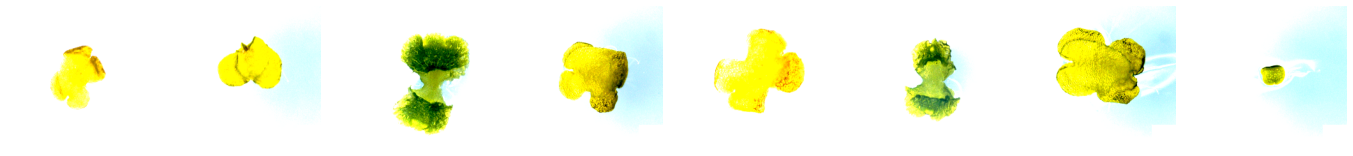

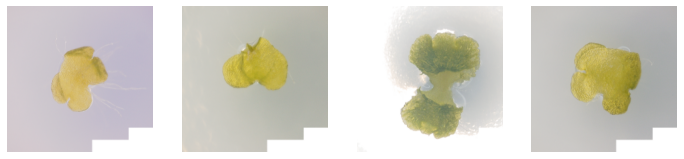

In [ ]:
### check images on a loader
unnormalize = get_unnormalize()
images, _ = next(iter(PCA_loader))
visualize_batch(images, ncols=8)
visualize_batch(unnormalize(images))


In [ ]:
## use a whole dataset.
## use transformation['valid'] (with no rotating/flip augmentations)
## use ResNet50 pre-trained model as a feature extractor

model = resnet50(pretrained=True)
model.to(dev)

def get_activation(name):# helper function from Pytorch forum to get activations in intermediate layers
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

activation = {}
features = []
model.avgpool.register_forward_hook(get_activation("features"))
## output of model.avgpool layer is stored in "activation["features"]"

model.eval()
labels_list = []
for inputs, labels in PCA_loader:
    # print(len(labels))
    inputs = inputs.to(dev)
    with torch.no_grad():
        model(inputs)
    features.append(activation["features"].cpu().numpy())
    labels_list.append(labels.numpy())

X= np.vstack(features)
X= X.reshape(X.shape[0], -1)

Y = np.concatenate(labels_list)
print(X.shape, Y.shape)


(6001, 2048) (6001,)


seed =  1000000
 perp =  10


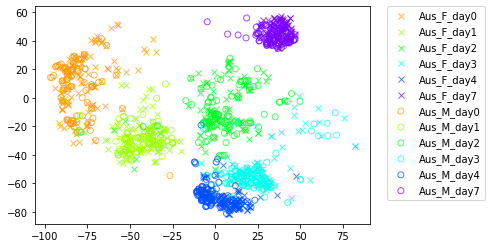

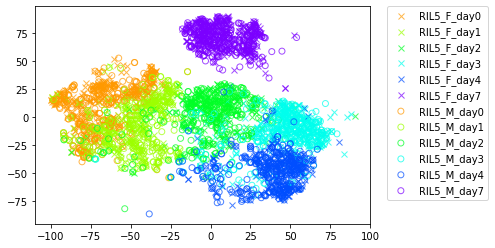

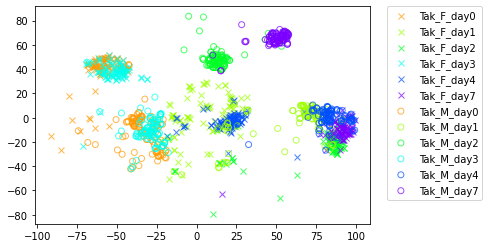

In [ ]:
results_path = './figures/tSNE/'
makedirs(results_path)
seed_list = [0, 1, 2, 3, 4, 5]
perp_list = [10, 20, 30, 40, 50]

days = [0, 1, 2, 3, 4, 7]
N_day = len(days)
colors = sns.color_palette("gist_rainbow", N_day)
FM = ['F', 'M']


for seed in seed_list:
  random_state = 1000000+seed
  print('seed = ', random_state)
  for perp in perp_list:
    print(' perp = ', perp)
    tsne = TSNE(n_components=2, random_state = random_state, perplexity = perp, n_iter = 1000)
    X_r = tsne.fit_transform(X)

    for strain_idx, strain in zip([0, 1, 2], ['Aus', 'RIL5', 'Tak']):
      fig, ax = plt.subplots(1,1)
      for FM_idx, marker in zip([0, 1], ['x', 'o']):
        i = 0
        for label, day in zip(np.arange(strain_idx*12 + FM_idx, strain_idx*12 + FM_idx+11, 2), days):
          # label:[ 0  2  4  6  8 10], [ 1  3  5  7  9 11], [12 14 16 18 20 22], [13 15 17 19 21 23]
          # Aus F - day 0,1,2,3,...,7 ;
          # Aus M - ... ;
          # RIL5 F - ... ;
          # RIL5 M - ...
          facecolor = 'none' if marker == 'o' else colors[i] #draw open circles when marker=='o'
          ax.scatter(X_r[Y == label, 0], X_r[Y == label, 1], color=colors[i], alpha=0.7, lw=1, label = strain + '_' + FM[FM_idx] + '_day' + str(day), marker = marker, facecolors=facecolor)
          i = i+1
      # plt.xlim([-80, 80])
      # plt.ylim([-90, 80])
      plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
      plt.savefig(results_path + 'tSNE_img224_ResNet50GAP_' + 'seed' + str(random_state) + '_perp' + str(perp) + '_' + strain + '.pdf', dpi=300)
      plt.savefig(results_path + 'tSNE_img224_ResNet50GAP_' + 'seed' + str(random_state) + '_perp' + str(perp) + '_'+ strain + '.png', dpi=300)

      plt.show()